## Summary

L'objectif est de construire un modèle de classification capable de **prédire si une personne gagne plus ou moins de 50 000 dollars par an**, en utilisant ses caractéristiques socio-démographiques.

Le jeu de données est **"Adult Income"** du [UCI Machine Learning Repository](https://archive.ics.uci.edu/).

- **[UCIMLREPO](https://github.com/uci-ml-repo/ucimlrepo) package**

Le package UCIMLRepo (pour **UCI Machine Learning Repository**) est une **bibliothèque Python** qui facilite l’accès aux jeux de données disponibles sur le célèbre dépôt [UCI Machine Learning Repository](https://archive.ics.uci.edu/). Il permet de **chercher, télécharger et utiliser facilement ces datasets directement dans un notebook Python**, sans avoir à passer par un téléchargement manuel.

## Packages

In [5]:
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

set_config(display='diagram')
pd.set_option("display.max_columns", None)

## Settings

In [6]:
EXECUTION_DATE = pendulum.now(tz="UTC")


ROOT_DIR = Path().cwd()
MODEL_DIR = Path(ROOT_DIR, "models")

MODEL_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Model directory: {MODEL_DIR}")

2025-05-06 16:27:19.294 | INFO     | __main__:<module>:8 - Model directory: c:\Users\HP\Desktop\temp\Projet\Machine_Learning2\TP\TP1\models


## Data collection

In [7]:
# check which datasets can be imported
list_available_datasets()

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale                                                                           12    
Balloons                       

In [8]:
# fetch dataset 
adult = fetch_ucirepo(name="Adult", id=None) 

# fetch data
data = adult.data.original

logger.info(f"{data.shape}")

2025-05-06 16:27:53.321 | INFO     | __main__:<module>:7 - (48842, 15)


In [9]:
data.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [10]:
# metadata 
logger.info(f"Metadata \n {adult.metadata}") 
  
# variable information 
logger.info(f"Features: \n{adult.variables}") 

2025-05-06 16:27:53.371 | INFO     | __main__:<module>:2 - Metadata 
 {'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census da

In [11]:
data.describe(include="all")

age workclass        fnlwgt education  education-num  \
count   48842.000000     47879  4.884200e+04     48842   48842.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     33906           NaN     15784            NaN   
mean       38.643585       NaN  1.896641e+05       NaN      10.078089   
std        13.710510       NaN  1.056040e+05       NaN       2.570973   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.175505e+05       NaN       9.000000   
50%        37.000000       NaN  1.781445e+05       NaN      10.000000   
75%        48.000000       NaN  2.376420e+05       NaN      12.000000   
max        90.000000       NaN  1.490400e+06       NaN      16.000000   

            marital-status      occupation relationship   race    sex  \
count                48842           47876        48842  48842  48842   
unique                   7              15            6      5      2   
top     Married-civ-spouse  Prof-specialty      Husband  White   Male   
freq                 22379            6172        19716  41762  32650   
mean                   NaN             NaN          NaN    NaN    NaN   
std                    NaN             NaN          NaN    NaN    NaN   
min                    NaN             NaN          NaN    NaN    NaN   
25%                    NaN             NaN          NaN    NaN    NaN   
50%                    NaN             NaN          NaN    NaN    NaN   
75%                    NaN             NaN          NaN    NaN    NaN   
max                    NaN             NaN          NaN    NaN    NaN   

        capital-gain  capital-loss  hours-per-week native-country income  
count   48842.000000  48842.000000    48842.000000          48568  48842  
unique           NaN           NaN             NaN             42      4  
top              NaN           NaN             NaN  United-States  <=50K  
freq             NaN           NaN             NaN          43832  24720  
mean     1079.067626     87.502314       40.422382            NaN    NaN  
std      7452.019058    403.004552       12.391444            NaN    NaN  
min         0.000000      0.000000        1.000000            NaN    NaN  
25%         0.000000      0.000000       40.000000            NaN    NaN  
50%         0.000000      0.000000       40.000000            NaN    NaN  
75%         0.000000      0.000000       45.000000            NaN    NaN  
max     99999.000000   4356.000000       99.000000            NaN    NaN

In [12]:
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


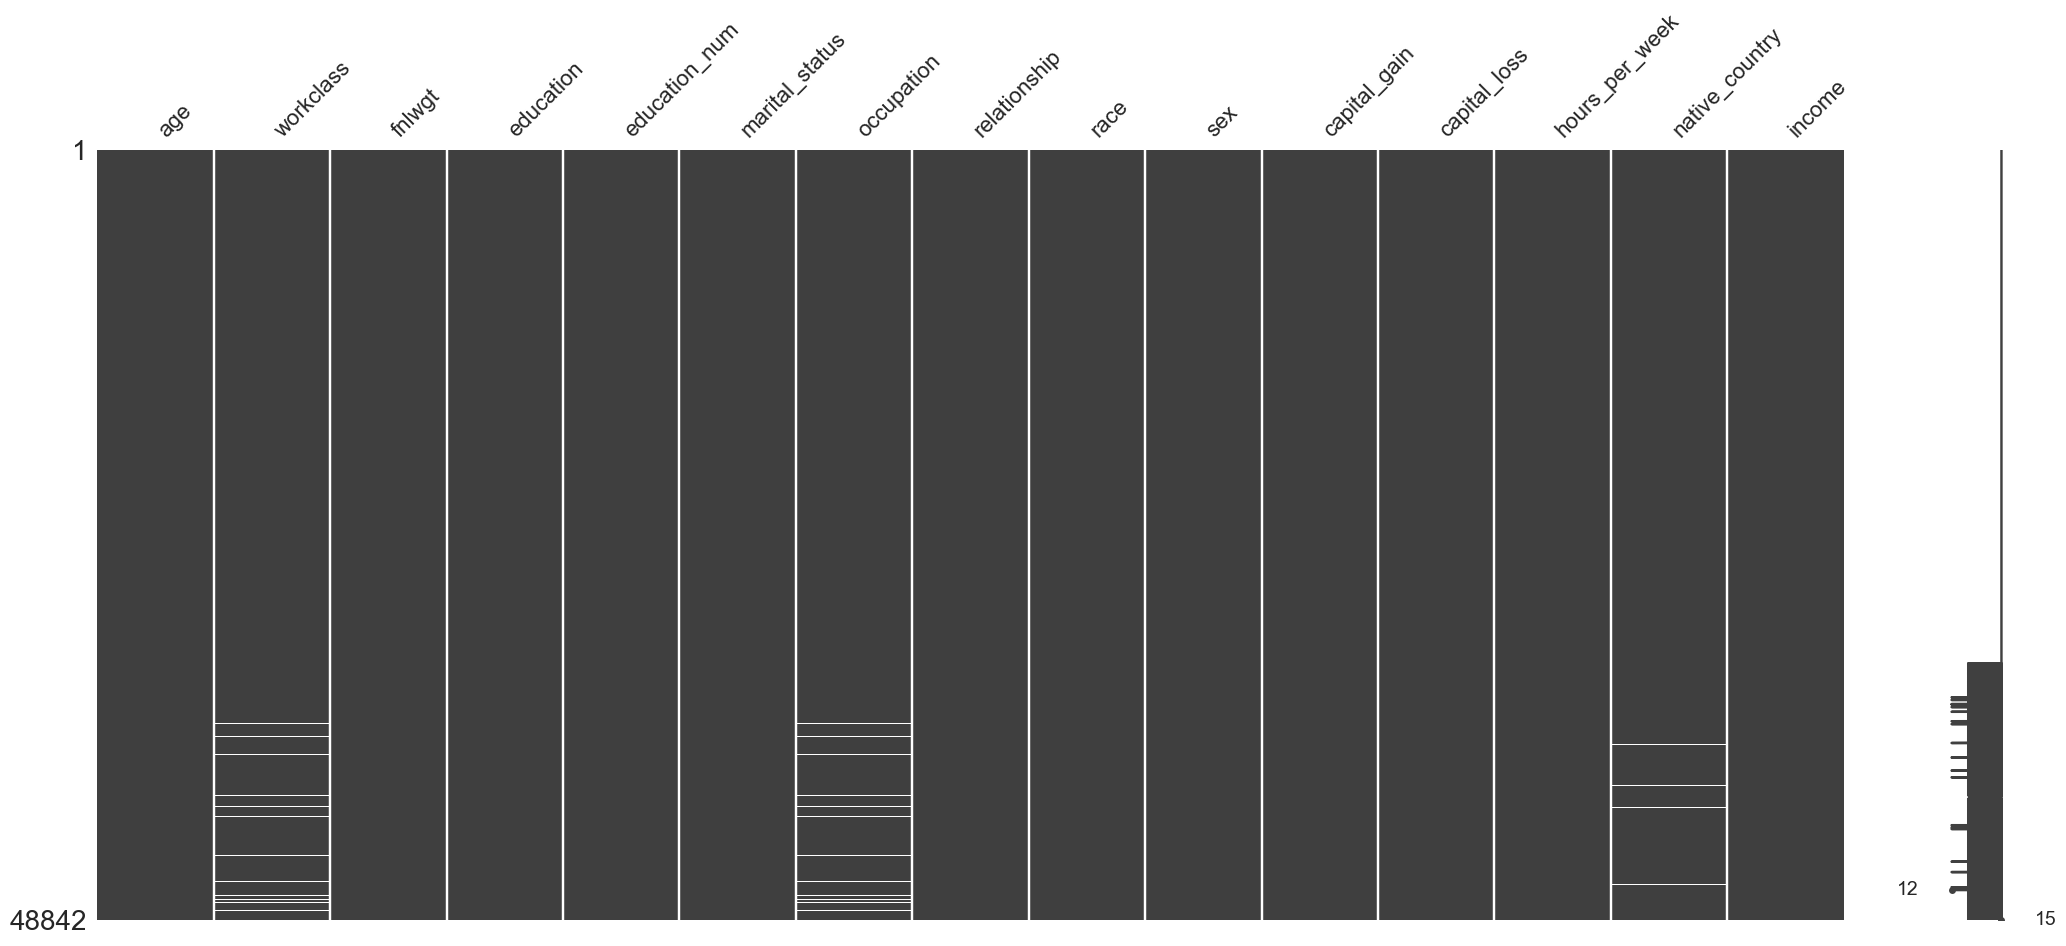

In [14]:
msno.matrix(data);

## EDA: Exploratory Data Analysis

In [15]:
data["income"].value_counts(normalize=False)

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

### Target

In [16]:
data = data.assign(income= lambda dfr: dfr.income.str.replace(".", ""))

In [17]:
label_distribution = data.groupby(['income']).size().reset_index(name='count')
label_distribution

income  count
0  <=50K  37155
1   >50K  11687

In [18]:
# Plot a pie chart with custom colors for income
fig = px.pie(
    label_distribution, 
    names='income',  # Use 'income' for pie segments
    values='count',  # Use 'count' for the size of each pie slice
    # color='income',  # Color the segments based on income
    title='Income distribution',
    labels={'income': 'Income', 'count': 'Count'},
)

fig.update_traces(textinfo='percent+label')  # Display percentage and labels on the pie chart

fig.show()

### Categorical features

In [19]:
categorical_columns = data.select_dtypes(include="object").columns

categorical_columns

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')

In [20]:
for col_name in categorical_columns:
    logger.info(f"{col_name} ==============\n {data[col_name].value_counts(dropna=False)}\n")

2025-05-06 16:27:56.333 | INFO     | __main__:<module>:2 - workclass ==============
 workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
NaN                   963
Without-pay            21
Never-worked           10
Name: count, dtype: int64

2025-05-06 16:27:56.337 | INFO     | __main__:<module>:2 - education ==============
 education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

2025-05-06 16:27:56.342 | INFO     | __main__:<module>:2 - marital_status ==============
 marital_status
Married-civ-spouse       22379
Never-ma

#### Preprocessing

In [21]:
# Replace “?” with None for all columns containing it
data.replace("?", None, inplace=True)

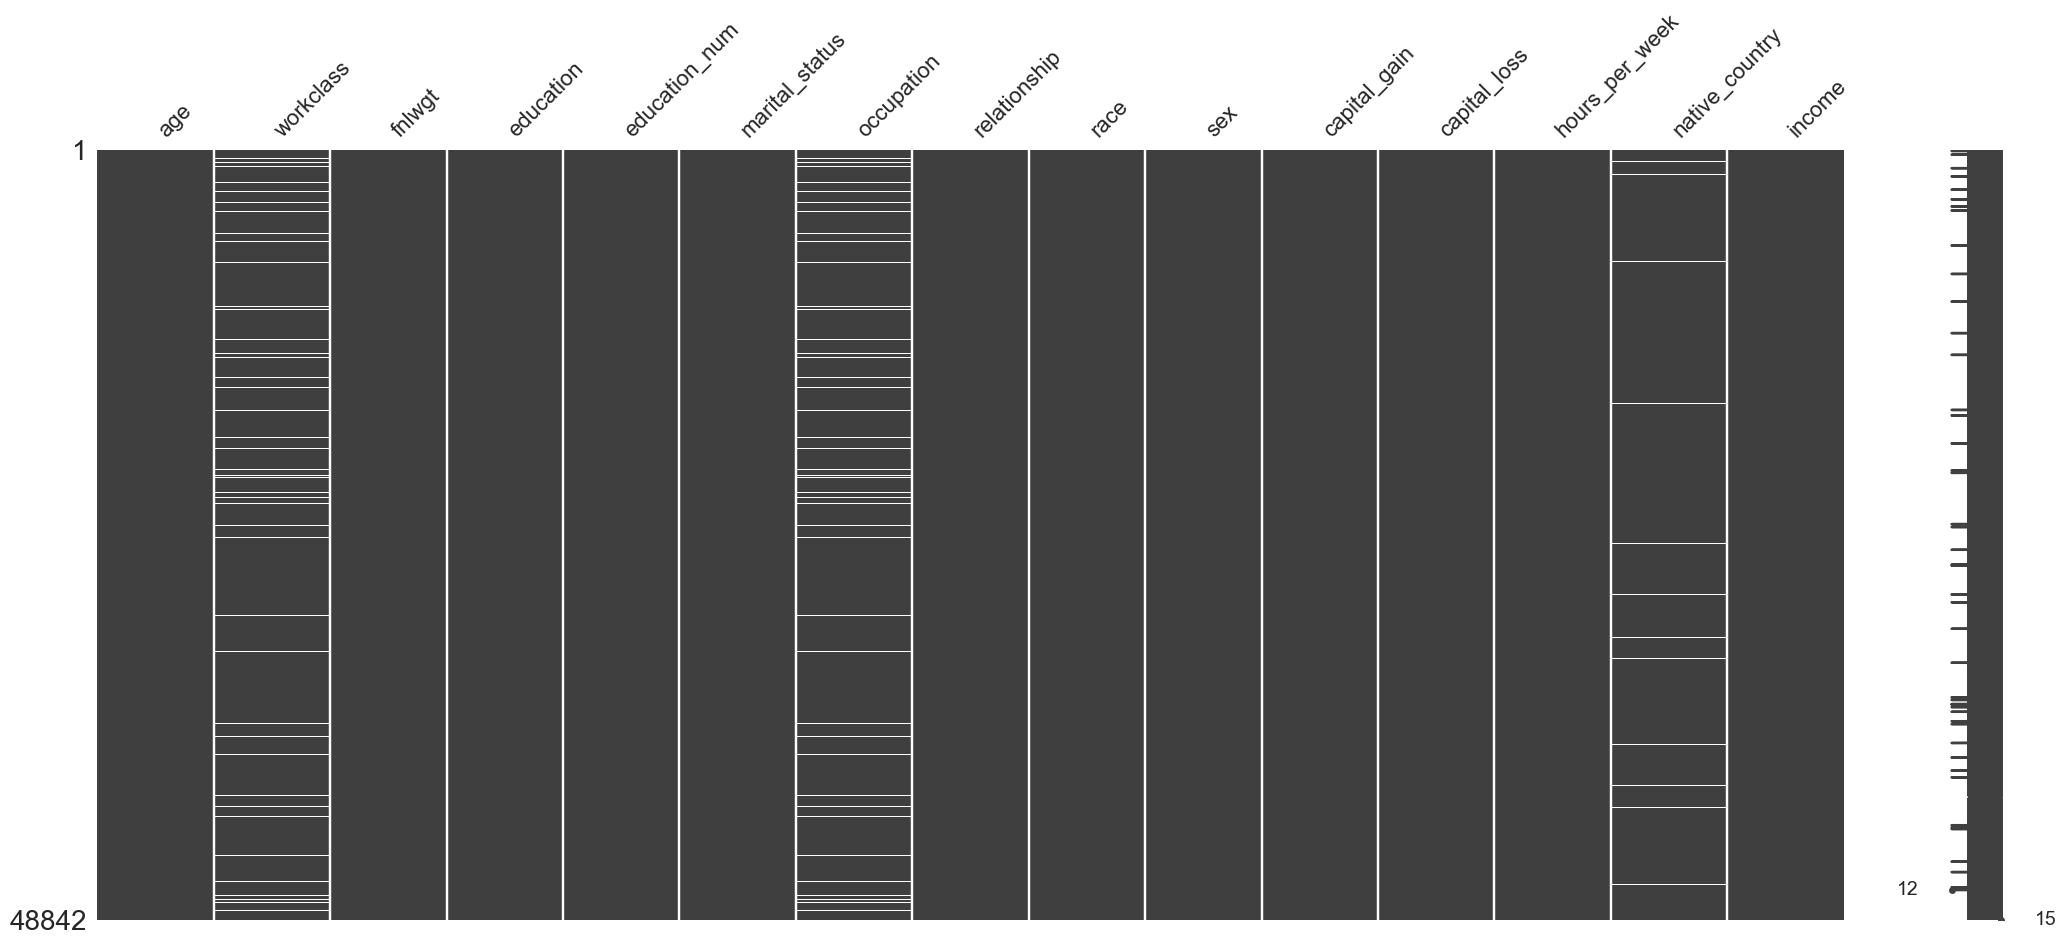

In [22]:
msno.matrix(data);

### Remove Duplicated

In [23]:
# Shape after deduplication
data.shape

(48842, 15)

In [24]:
# Check for the duplicates: if True then there are duplicated
data.duplicated().any()

np.True_

In [25]:
data[data.duplicated(keep=False)].sort_values(["workclass", "education", "relationship"])

age workclass  fnlwgt     education  education_num marital_status  \
24667   17   Private  153021          12th              8  Never-married   
36713   17   Private  153021          12th              8  Never-married   
5842    25   Private  195994       1st-4th              2  Never-married   
13084   25   Private  195994       1st-4th              2  Never-married   
22300   25   Private  195994       1st-4th              2  Never-married   
...    ...       ...     ...           ...            ...            ...   
38993   22       NaN  334593  Some-college             10  Never-married   
10094   19      None  167428  Some-college             10  Never-married   
30384   20      None  203353  Some-college             10  Never-married   
34424   20       NaN  203353  Some-college             10  Never-married   
40677   19       NaN  167428  Some-college             10  Never-married   

            occupation   relationship   race     sex  capital_gain  \
24667            Sales      Own-child  White  Female             0   
36713            Sales      Own-child  White  Female             0   
5842   Priv-house-serv  Not-in-family  White  Female             0   
13084  Priv-house-serv  Not-in-family  White  Female             0   
22300  Priv-house-serv  Not-in-family  White  Female             0   
...                ...            ...    ...     ...           ...   
38993              NaN  Not-in-family  White    Male             0   
10094             None      Own-child  White    Male             0   
30384             None      Own-child  White  Female             0   
34424              NaN      Own-child  White  Female             0   
40677              NaN      Own-child  White    Male             0   

       capital_loss  hours_per_week native_country income  
24667             0              20  United-States  <=50K  
36713             0              20  United-States  <=50K  
5842              0              40      Guatemala  <=50K  
13084             0              40      Guatemala  <=50K  
22300             0              40      Guatemala  <=50K  
...             ...             ...            ...    ...  
38993             0              40  United-States  <=50K  
10094             0              40  United-States  <=50K  
30384             0              40  United-States  <=50K  
34424             0              40  United-States  <=50K  
40677             0              40  United-States  <=50K  

[101 rows x 15 columns]

In [26]:
# Drop duplicates
data = data.drop_duplicates(keep='first', inplace=False)
data.shape

(48790, 15)

In [27]:
# Shape after deduplication
data.shape

(48790, 15)

### Numerical features

In [28]:
data["capital_diff"] = data['capital_gain'] - data['capital_loss']

In [29]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [30]:
# Initialize a figure
fig = go.Figure()

# Iterate over numeric columns in the DataFrame
for column in numeric_columns:
    fig.add_trace(go.Box(
        y=data[column],
        name=column,
        marker=dict(color='skyblue')
    ))

# Update layout with a title and axis labels
fig.update_layout(
    title='Distribution of Numeric Columns without Outliers',
    yaxis_title='Values',
    xaxis_title='Numeric Columns'
)

# Show the figure
fig.show()


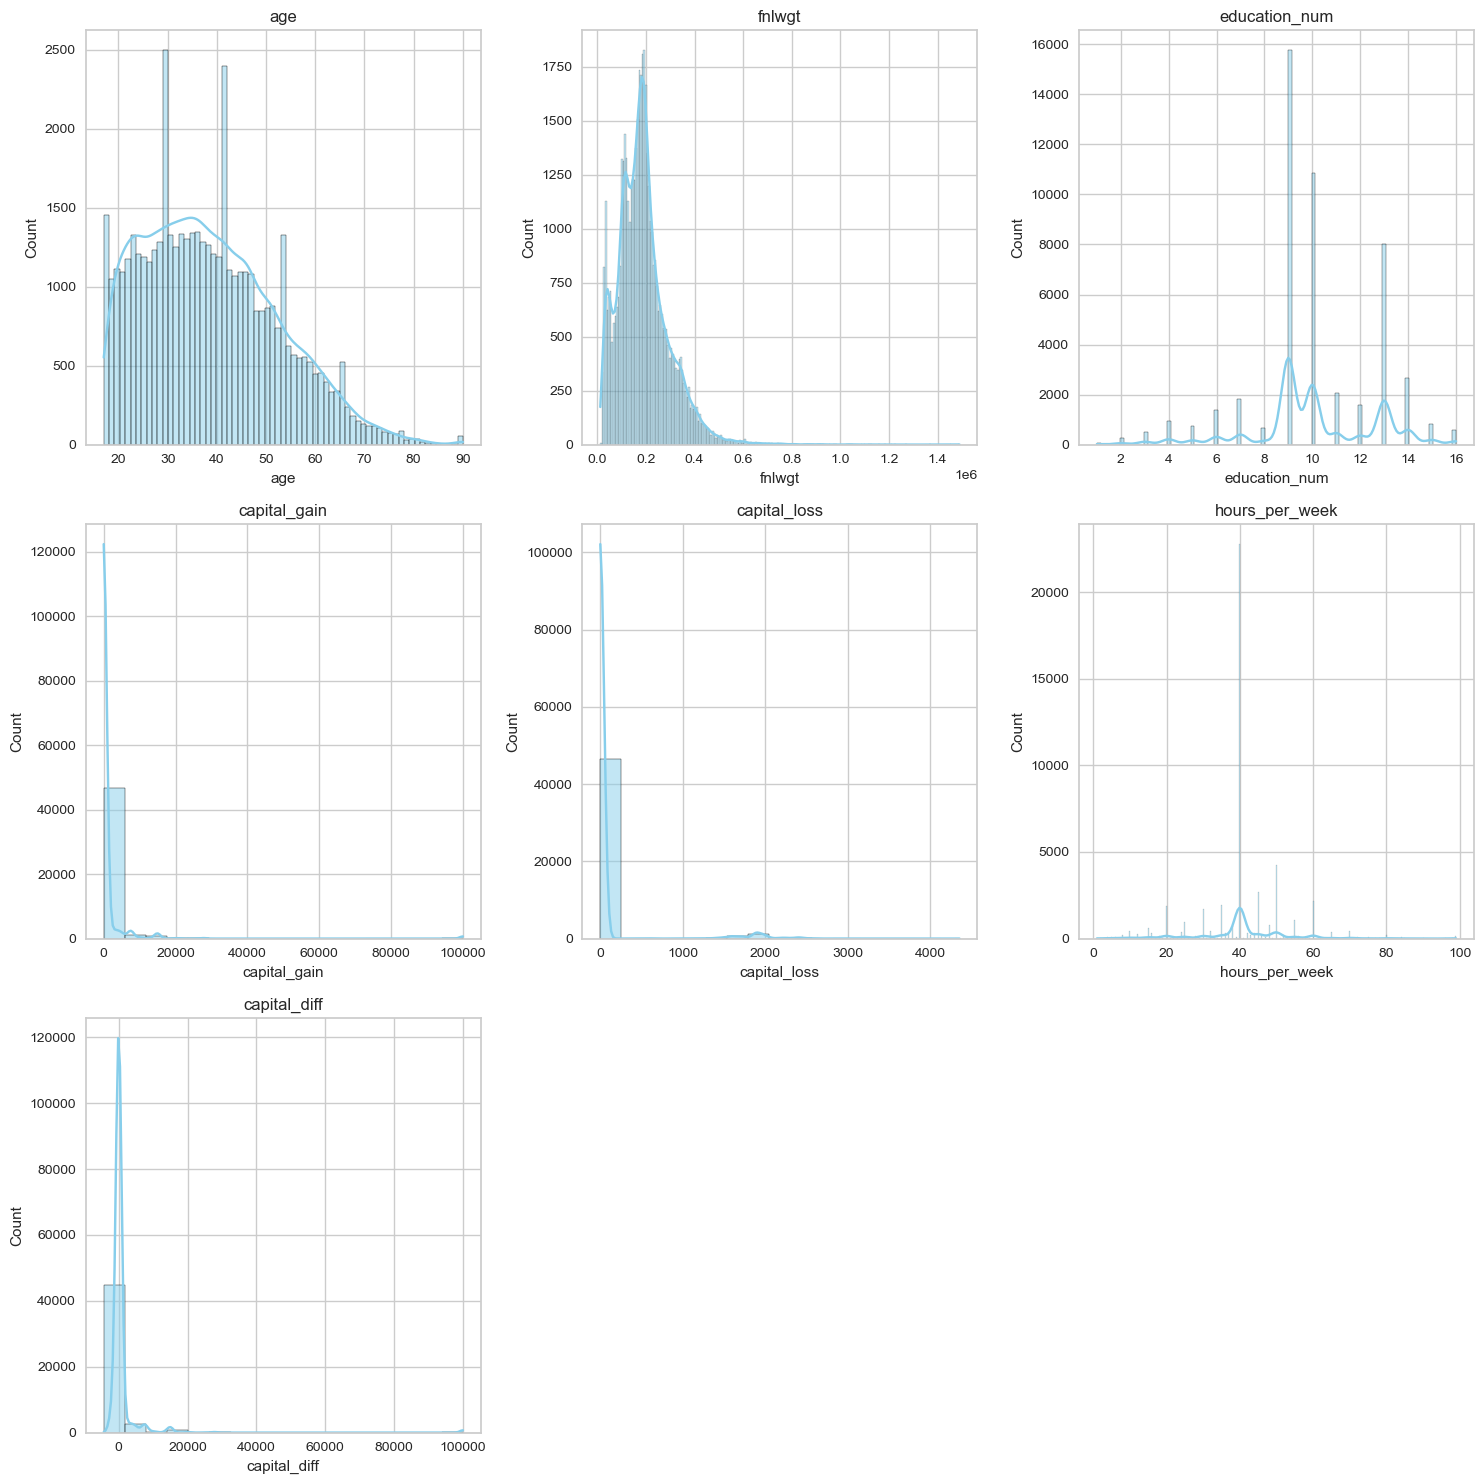

In [31]:
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_columns):
    sns.histplot(data[col_name], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col_name)
    
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Bivariate analysis

In [32]:
px.box(
    data,
    x='income',  # Income category on the x-axis
    y='age',  # Age distribution on the y-axis
    title='Age Distribution by Income',
    labels={'income': 'Income Category', 'age': 'Age'}
)

In [33]:
data

age         workclass  fnlwgt  education  education_num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital_status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2                Divorced  Handlers-cleaners   Not-in-family   
3      Married-civ-spouse  Handlers-cleaners         Husband   
4      Married-civ-spouse     Prof-specialty            Wife   
...                   ...                ...             ...   
48837            Divorced     Prof-specialty   Not-in-family   
48838             Widowed                NaN  Other-relative   
48839  Married-civ-spouse     Prof-specialty         Husband   
48840            Divorced       Adm-clerical       Own-child   
48841  Married-civ-spouse    Exec-managerial         Husband   

                     race     sex  capital_gain  capital_loss  hours_per_week  \
0                   White    Male          2174             0              40   
1                   White    Male             0             0              13   
2                   White    Male             0             0              40   
3                   Black    Male             0             0              40   
4                   Black  Female             0             0              40   
...                   ...     ...           ...           ...             ...   
48837               White  Female             0             0              36   
48838               Black    Male             0             0              40   
48839               White    Male             0             0              50   
48840  Asian-Pac-Islander    Male          5455             0              40   
48841               White    Male             0             0              60   

      native_country income  capital_diff  
0      United-States  <=50K          2174  
1      United-States  <=50K             0  
2      United-States  <=50K             0  
3      United-States  <=50K             0  
4               Cuba  <=50K             0  
...              ...    ...           ...  
48837  United-States  <=50K             0  
48838  United-States  <=50K             0  
48839  United-States  <=50K             0  
48840  United-States  <=50K          5455  
48841  United-States   >50K             0  

[48790 rows x 16 columns]

In [34]:
for col_name in ["workclass",
                 "education",
                 "marital_status",
                 "sex"
                ]:

    feature_income_counts = data.groupby([col_name, 'income']).size().unstack()
    
    fig = px.bar(feature_income_counts,
                 barmode='stack',  # Stack bars for income categories
                 title=f'Relationship between Income and {col_name}',
                 labels={'value': 'Count'}
                )
    fig.show()

In [35]:
for col_name in numeric_columns:

    #counts
    num_feat_income_counts = data.groupby([col_name, "income"]).size().unstack()
    
    # Plot using iplot
    fig = px.area(num_feat_income_counts,
                  title=f"Relationship between {col_name} and income",
                  labels={"value": "Count"}
                 )
    fig.show()

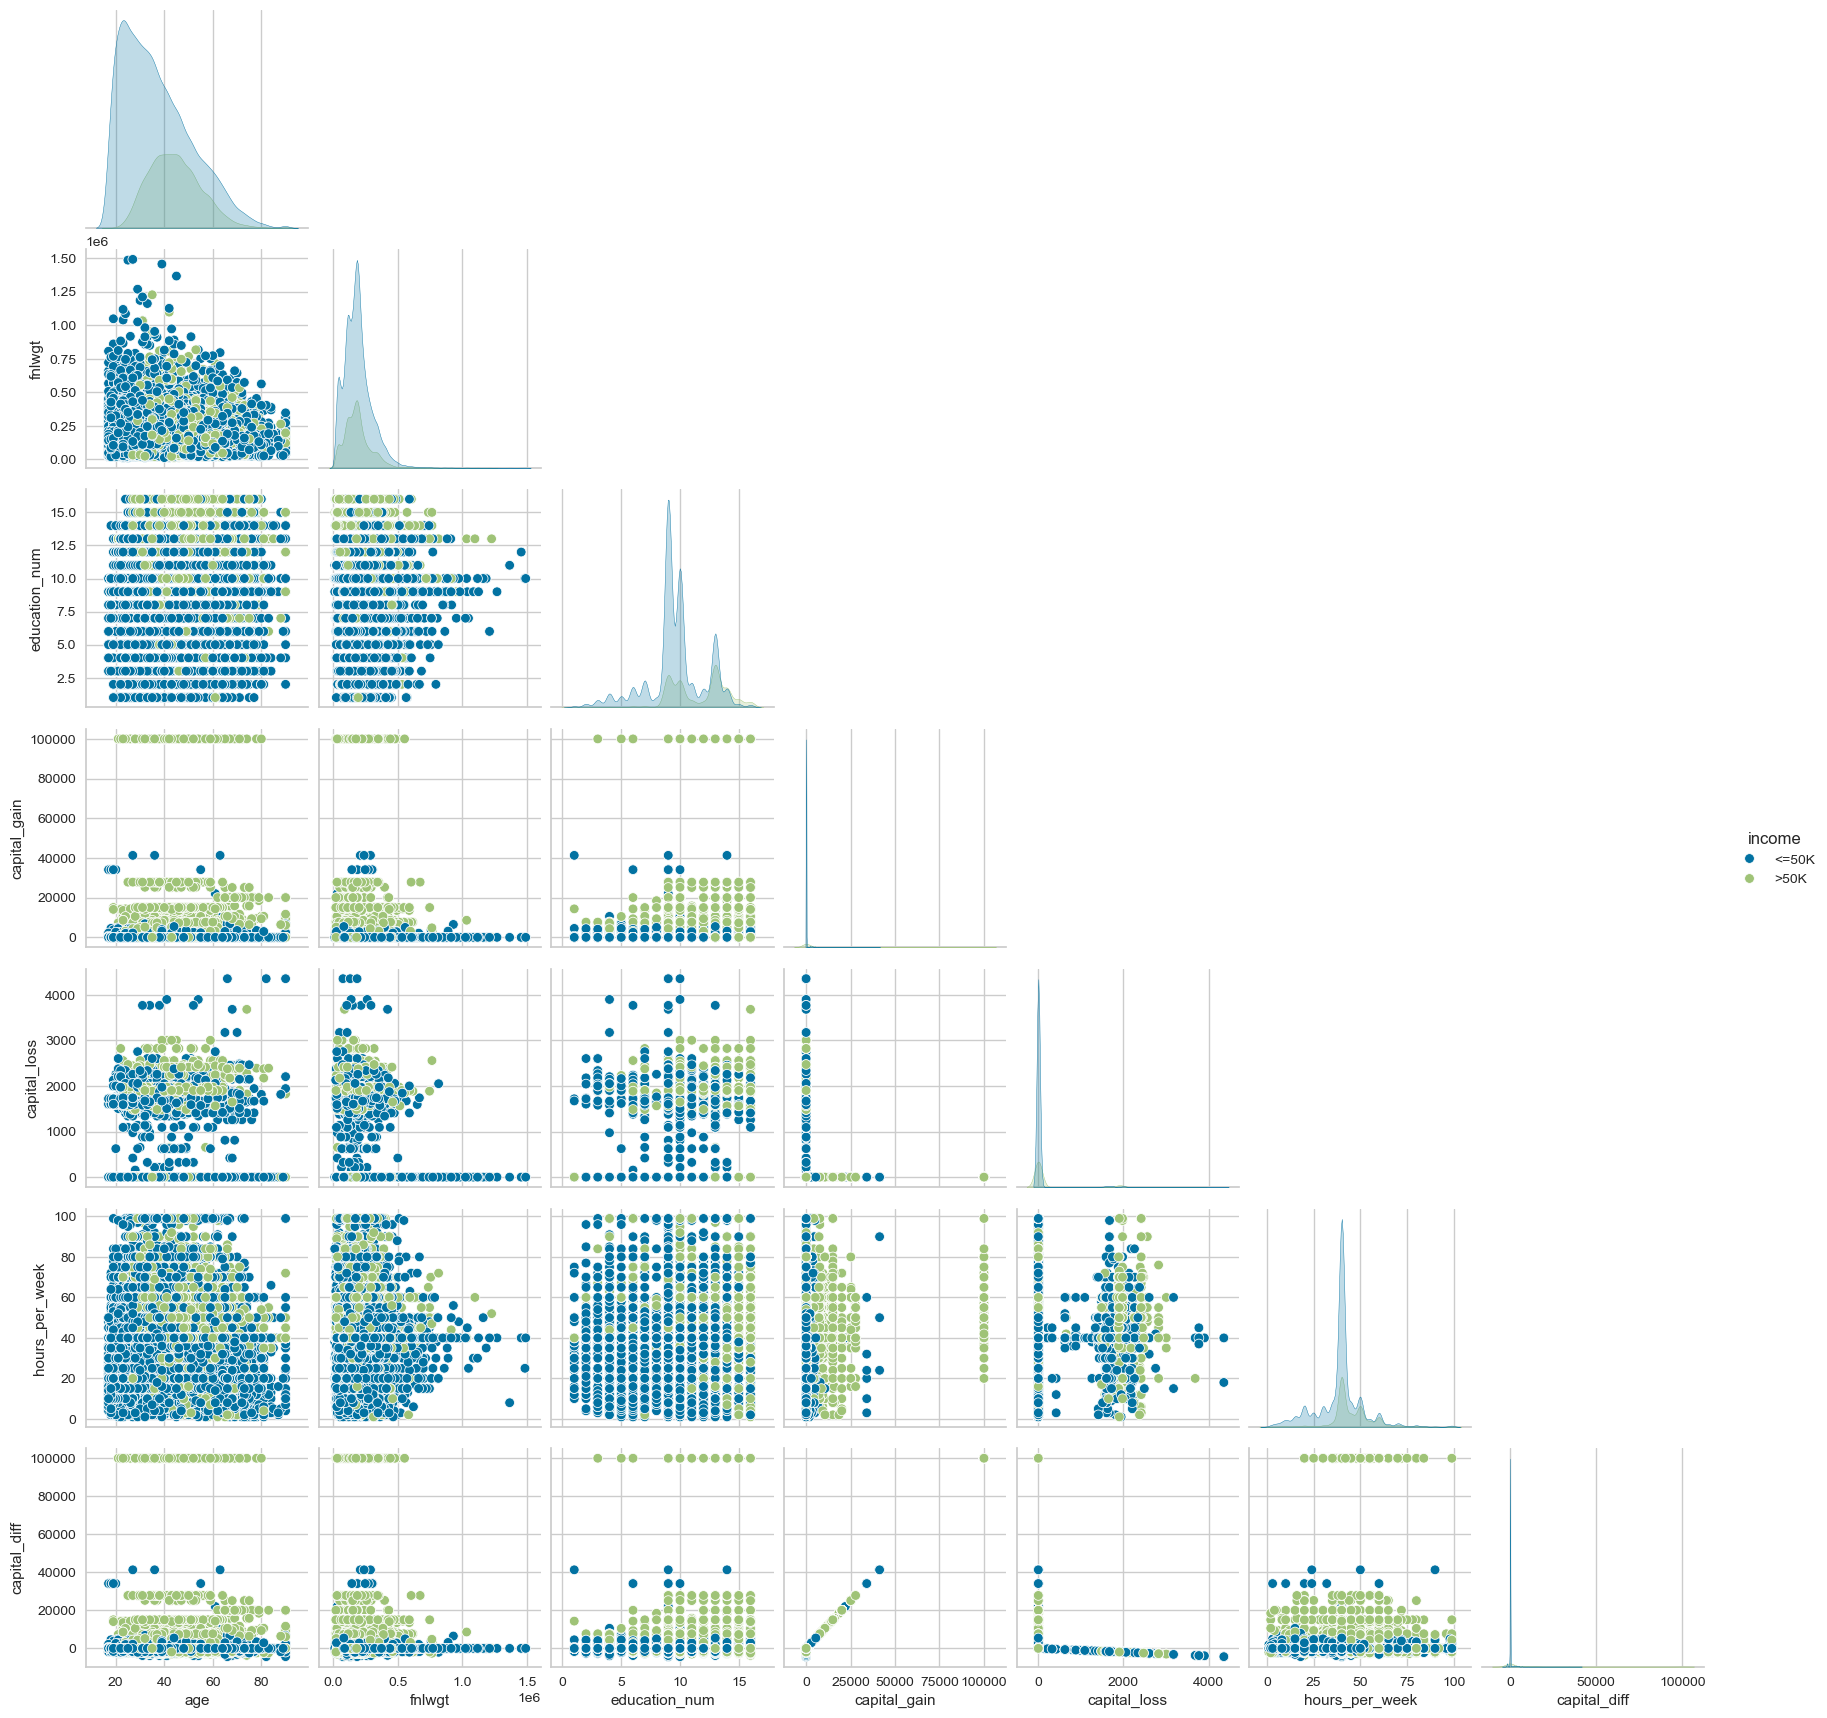

In [36]:
sns.pairplot(data, hue="income", corner=True);

### Correlation

In [37]:
corr_matrix = data.loc[:, numeric_columns].corr()


In [38]:
data.loc[:, numeric_columns].corr()

age    fnlwgt  education_num  capital_gain  capital_loss  \
age             1.000000 -0.076451       0.030635      0.077185      0.056838   
fnlwgt         -0.076451  1.000000      -0.038727     -0.003715     -0.004378   
education_num   0.030635 -0.038727       1.000000      0.125219      0.080986   
capital_gain    0.077185 -0.003715       0.125219      1.000000     -0.031475   
capital_loss    0.056838 -0.004378       0.080986     -0.031475      1.000000   
hours_per_week  0.071223 -0.013521       0.143915      0.082152      0.054431   
capital_diff    0.073878 -0.003467       0.120459      0.998547     -0.085285   

                hours_per_week  capital_diff  
age                   0.071223      0.073878  
fnlwgt               -0.013521     -0.003467  
education_num         0.143915      0.120459  
capital_gain          0.082152      0.998547  
capital_loss          0.054431     -0.085285  
hours_per_week        1.000000      0.078959  
capital_diff          0.078959      1.000000

<Axes: >

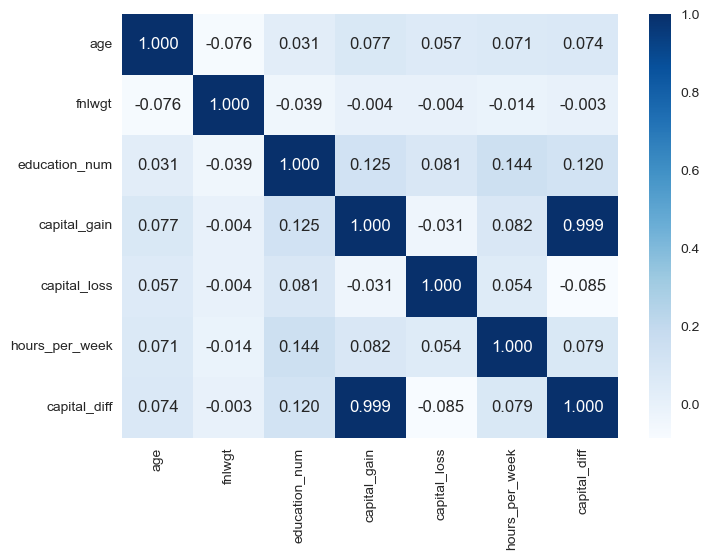

In [39]:
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="Blues")

## Data preparation

In [40]:
data.head()

age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  \
0          2174             0              40  United-States  <=50K   
1             0             0              13  United-States  <=50K   
2             0             0              40  United-States  <=50K   
3             0             0              40  United-States  <=50K   
4             0             0              40           Cuba  <=50K   

   capital_diff  
0          2174  
1             0  
2             0  
3             0  
4             0

In [41]:
# Removing rows where 'Workclass' is 'Without-pay' and 'Never-worked'
data = data[~data["workclass"].str.lower().isin(["without-pay", "never-worked"])
            # & data["hours_per_week"].between(20, 60)
           ]
data.shape

(48759, 16)

In [42]:
data["hours_per_week"].value_counts(sort=False).sort_index()

hours_per_week
1      27
2      53
3      59
4      83
5      95
     ... 
95      2
96      9
97      2
98     14
99    137
Name: count, Length: 96, dtype: int64

In [43]:
#Feature mapping
workclass_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-Employed',
    'Local-gov': 'Government',
    'State-gov': 'Government',
    'Self-emp-inc': 'Self-Employed',
    'Federal-gov': 'Government',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}

marital_status_mapping = {
    "Married-civ-spouse": "Married",
    "Married-spouse-absent": "Married",
    "Married-AF-spouse": "Married",
    "Separated": "Married",
    "Never-married": "Single",
    "Divorced": "Single",
    "Widowed": "Single"
}

relationship_mapping = {
    'Husband': 'spouse',
    'Not-in-family': 'Others:',
    'Own-child': 'Immediate Family',
    'Unmarried': 'Others:',
    'Wife': 'spouse',
    'Other-relative': 'Immediate Family',
}

# occupation
# occupation_mapping = to be defined if necessary

In [44]:
data = data.assign(income=lambda dfr: dfr['income'].map({"<=50K": 0, ">50K": 1}),
                   # capital_diff_bin = lambda dfr: pd.cut(dfr['capital_diff'], bins = [-5000, 5000, 100000], labels = ['Low', 'High'])
                   native_country=lambda dfr: dfr["native_country"].fillna("United-States").map(lambda val: val if val == "United-States" else "Others"),
                   education=lambda dfr: dfr.education.replace(["11th", "9th", "7th-8th", "5th-6th", "10th", "1st-4th", "12th"], "School"),
                   race=lambda dfr: dfr.race.map(lambda val: 'White' if val == 'White' else 'Others'),
                   # workclass=lambda dfr: dfr.workclass.map(workclass_mapping),
                   # marital_status=lambda dfr: dfr.marital_status.map(marital_status_mapping),
                   # relationship=lambda dfr: dfr.relationship.map(relationship_mapping),
                  )

## Train / test split

In [45]:
data.drop(['capital_gain',
           'capital_loss',
           "fnlwgt",  # fnlwgt (Final Weight): Represents the weight assigned to each individual.
           "education_num",
       ], axis=1, inplace=True)
      

In [46]:
x_values = data.drop(columns=['income'])  
y_target = data.income

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [48]:
x_train.head()

age         workclass     education      marital_status  \
44101   35         Local-gov     Bachelors  Married-civ-spouse   
36845   61           Private       HS-grad            Divorced   
44706   41           Private  Some-college            Divorced   
35127   49  Self-emp-not-inc        School  Married-civ-spouse   
41678   37  Self-emp-not-inc     Assoc-voc  Married-civ-spouse   

              occupation   relationship   race     sex  hours_per_week  \
44101    Protective-serv        Husband  White    Male              48   
36845  Machine-op-inspct  Not-in-family  White  Female              40   
44706              Sales      Unmarried  White    Male              46   
35127    Farming-fishing        Husband  White    Male              50   
41678    Farming-fishing        Husband  White    Male              60   

      native_country  capital_diff  
44101  United-States             0  
36845  United-States             0  
44706  United-States             0  
35127  United-States             0  
41678  United-States             0

In [49]:
y_train.value_counts(normalize=True).mul(100).round(2)

income
0    76.05
1    23.95
Name: proportion, dtype: float64

In [50]:
y_train.value_counts(normalize=True).mul(100).round(2)

income
0    76.05
1    23.95
Name: proportion, dtype: float64

### Feature engineering

In [51]:
x_values.head()

age         workclass  education      marital_status         occupation  \
0   39         State-gov  Bachelors       Never-married       Adm-clerical   
1   50  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2   38           Private    HS-grad            Divorced  Handlers-cleaners   
3   53           Private     School  Married-civ-spouse  Handlers-cleaners   
4   28           Private  Bachelors  Married-civ-spouse     Prof-specialty   

    relationship    race     sex  hours_per_week native_country  capital_diff  
0  Not-in-family   White    Male              40  United-States          2174  
1        Husband   White    Male              13  United-States             0  
2  Not-in-family   White    Male              40  United-States             0  
3        Husband  Others    Male              40  United-States             0  
4           Wife  Others  Female              40         Others             0

In [52]:
# numerical
numeric_features = x_values.select_dtypes(include="number").columns

# categorical
onehot_features = ['workclass', 'occupation', 'relationship', 'race', 'sex', 'marital_status']

country_feature = ["native_country"]
ordinal_features = ['education',
                   # 'capital_diff_bin',
                  ]
    
cat_for_edu = ['Preschool', 'School', 'HS-grad','Some-college', 'Assoc-voc', 'Assoc-acdm','Bachelors', 'Masters', 'Prof-school', 'Doctorate']
cat_for_capdiff = ['Low', 'High']

In [53]:
x_train.loc[:, numeric_features]

age  hours_per_week  capital_diff
44101   35              48             0
36845   61              40             0
44706   41              46             0
35127   49              50             0
41678   37              60             0
...    ...             ...           ...
2324    63              50             0
30520   21              40             0
42196   60              25             0
41858   34              40             0
26127   19              35             0

[39007 rows x 3 columns]

In [54]:
x_train.loc[:, numeric_features]

age  hours_per_week  capital_diff
44101   35              48             0
36845   61              40             0
44706   41              46             0
35127   49              50             0
41678   37              60             0
...    ...             ...           ...
2324    63              50             0
30520   21              40             0
42196   60              25             0
41858   34              40             0
26127   19              35             0

[39007 rows x 3 columns]

In [55]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Education : ordinal + imputation 'undefined' gérée via catégorie manquante
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('ordinal', OrdinalEncoder(categories=[cat_for_edu + ['undefined']], handle_unknown='use_encoded_value', unknown_value=-1))
])

# OneHot : autres variables catégorielles avec imputation "undefined"
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Native country : imputation avec "United-States"
country_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='United-States')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('ord', ordinal_transformer, ordinal_features),
    ('cat', onehot_transformer, onehot_features),
    ('country', country_transformer, country_feature)
])



preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Preschool',
                                                                              'School',
                                                                              'HS-...
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'occupation', 'relationship',
                                  'race', 'sex', 'marital_status']),
                                ('country',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='United-States',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['native_country'])])

## Modeling

#### Dummy regressor

In [56]:
# Pipeline
dm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier())
])

dm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', DummyClassifier())])

In [57]:
# Training
dm_pipeline.fit(x_train, y_train)

# Predictions & evaluation
dm_y_pred_test = dm_pipeline.predict(x_test)
dm_y_proba_test = dm_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, dm_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, dm_y_pred_test)}")

2025-05-06 16:29:31.478 | INFO     | __main__:<module>:9 - AUC: 0.50
c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2025-05-06 16:29:31.491 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0   

#### Logistic regression

In [58]:
# Pipeline
rl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

rl_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', LogisticRegression(max_iter=1000))])

##### Baseline

In [59]:
# 8. Entraînement
rl_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
rl_y_pred_test = rl_pipeline.predict(x_test)
rl_y_proba_test = rl_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, rl_y_proba_test):.2f} ")

logger.info(f"Classification report: \n{classification_report(y_test, rl_y_pred_test)}")

2025-05-06 16:29:32.258 | INFO     | __main__:<module>:9 - AUC: 0.90 
2025-05-06 16:29:32.273 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7416
           1       0.72      0.59      0.65      2336

    accuracy                           0.85      9752
   macro avg       0.80      0.76      0.78      9752
weighted avg       0.84      0.85      0.84      9752



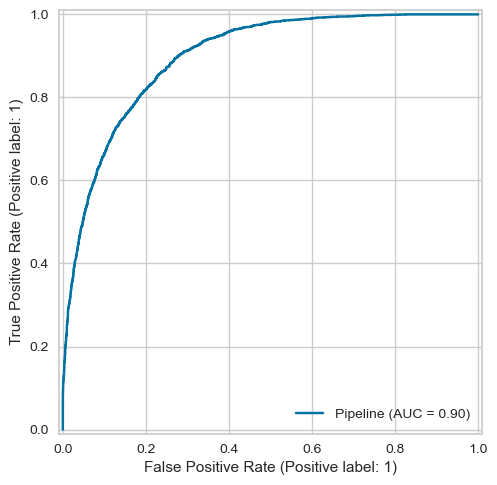

In [60]:
RocCurveDisplay.from_estimator(rl_pipeline, x_test, y_test);

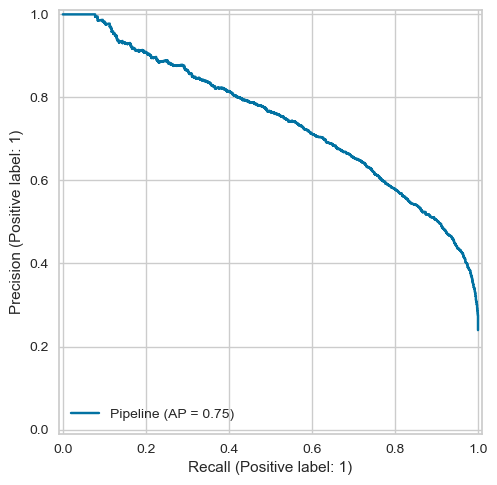

In [61]:
PrecisionRecallDisplay.from_estimator(rl_pipeline, x_test, y_test);


##### Tuning hyperparameters

In [62]:
rl_param_grid = {
    "clf__penalty": ["l2"],  # 'l1' si solver = 'liblinear' ou 'saga'
    "clf__C": [0.01, 0.1, 1, 2, 3, 5, 10],
    "clf__solver": ['liblinear', 'lbfgs', "sag", "saga"],  # lbfgs ne supporte que l2
    "clf__class_weight": ['balanced', None],
}

In [63]:
# Cross-validation
cv = StratifiedKFold(n_splits=5) 

rl_grid_search = GridSearchCV(rl_pipeline, rl_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Training
rl_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {rl_grid_search.best_params_}")

# Evaluation
rl_y_pred_test_opt = rl_grid_search.predict(x_test)
rl_y_proba_test_opt  = rl_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, rl_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rl_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rl_y_pred_test_opt):.2f}")


2025-05-06 16:34:39.113 | INFO     | __main__:<module>:10 - Best params : {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
2025-05-06 16:34:39.345 | INFO     | __main__:<module>:16 - AUC : 0.90
2025-05-06 16:34:39.362 | INFO     | __main__:<module>:17 - F1-score : 0.66
2025-05-06 16:34:39.372 | INFO     | __main__:<module>:18 - Accuracy : 0.79


##### Discrimination threshold

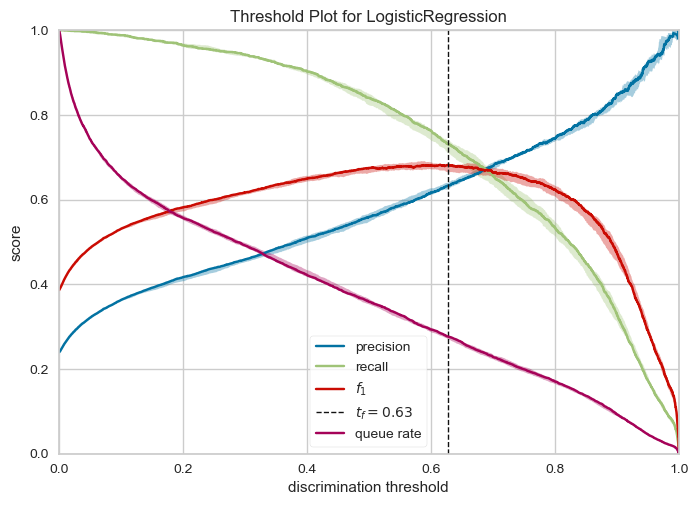

In [64]:
viz = DiscriminationThreshold(rl_grid_search.best_estimator_, random_state=42, fbeta=1.0, cv=cv, argmax="fscore")

# Fit et plot
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show();

##### Model analysis

In [65]:
# features importances

##### Save model

In [66]:
# Save model

model_path_name = Path(MODEL_DIR, "best_logistic_model.dill")

logger.info(f"Model path name: {model_path_name}")
with open(model_path_name, "wb") as fp:
    dill.dump(rl_grid_search.best_estimator_, fp)

2025-05-06 16:38:06.816 | INFO     | __main__:<module>:5 - Model path name: c:\Users\HP\Desktop\temp\Projet\Machine_Learning2\TP\TP1\models\best_logistic_model.dill


### KNN

#### Baseline

In [67]:
# Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', KNeighborsClassifier(n_neighbors=10))])

In [68]:
# 8. Entraînement
knn_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
knn_y_pred_test = knn_pipeline.predict(x_test)
knn_y_proba_test = knn_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, knn_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, knn_y_pred_test)}")

2025-05-06 16:38:43.924 | INFO     | __main__:<module>:9 - AUC: 0.88
2025-05-06 16:38:43.942 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7416
           1       0.72      0.56      0.63      2336

    accuracy                           0.84      9752
   macro avg       0.80      0.74      0.76      9752
weighted avg       0.83      0.84      0.83      9752



In [69]:
class_names = data["income"].unique()
print(class_names)

[0 1]


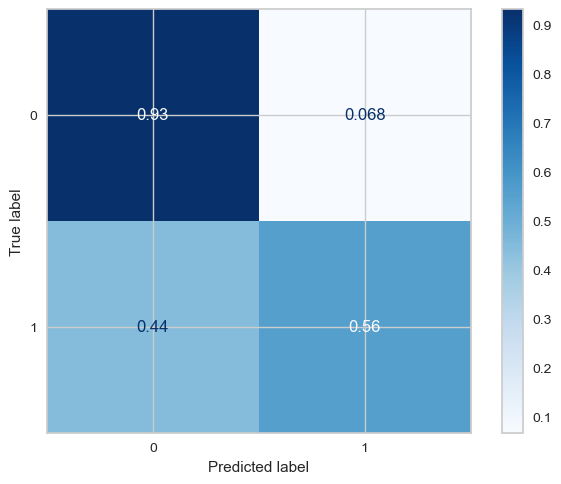

In [70]:
ConfusionMatrixDisplay.from_estimator(knn_pipeline, x_test, y_test,
                                      display_labels=class_names,
                                      normalize="true", cmap=plt.cm.Blues);

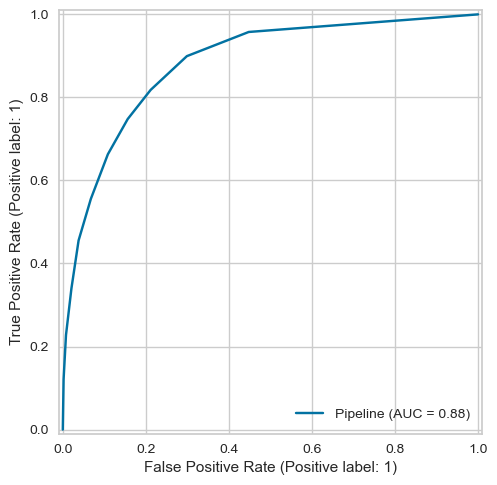

In [71]:
RocCurveDisplay.from_estimator(knn_pipeline, x_test, y_test);

# TP 1 - MOUSSA DIEME
> - Entraîner / optimiser 2 modèles ensemblistes
> - Choisir le meilleur modèle parmi tous ceux qu'on a entraîné
> - Étudier la feature importance global et local avec shap
> - Optimiser si besoin le modèle et l'enregistrer au format .dill

In [72]:
# Nous allons entrainer un modele randomforestClassifier et un modele LGBMClassifier (bagging & boosting)
# LGBMClassifier n'est pas implémenté  dans scikit-learn, à la place nous allons choisir le pqckage lightgbm

In [73]:
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

## modéle randomforestClassifier sans optimisation

In [74]:
randomForest_model=Pipeline([('preprocessor', preprocessor),
                        ('clf', RandomForestClassifier(random_state=221, n_jobs=-1))]) # n_jobs= -1 pour utuliser tous le cpu
randomForest_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=221))])

In [75]:
randomForest_model.fit (x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=221))])

In [76]:
# Passons à la prédiction
y_predict_rf=randomForest_model.predict(x_test)
print(classification_report(y_test, y_predict_rf))


              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7416
           1       0.70      0.63      0.66      2336

    accuracy                           0.85      9752
   macro avg       0.79      0.77      0.78      9752
weighted avg       0.84      0.85      0.84      9752



In [77]:
cm = confusion_matrix(y_test, y_predict_rf)
labels = ['≤50K', '>50K']
annot_text = [[f'<b>{value}</b>' for value in row] for row in cm]

fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=labels,
    y=labels,
    text=annot_text,
    texttemplate="%{text}",
    textfont={"size": 20},
    colorscale='Viridis',
    reversescale=True,
    showscale=True,
    hovertemplate='Réel: %{y}<br>Prédiction: %{x}<br>Valeur: %{z}<extra></extra>'
))
fig.update_yaxes(autorange='reversed') # fix bug inverser l'ordre des etiquettes de l'axe des y
fig.update_layout(
    title=' Matrice de confusion - Random Forest ',
    xaxis_title='Prédictions',
    yaxis_title='Valeurs réelles',
    width=700,
    height=500,
    font=dict(size=16),
    margin=dict(l=50, r=50, t=60, b=50)
)

fig.show()


Nous avons une bonne précision global,85% . Les individus gagnant moins de 50.000 dollard par ans sont bien détecter,avec un rappel de 91% .En revanche la classe minoritaire est détecter avec un faible rappel de  63% . Nous allons par la suite entre autre ajuster le seul de classification afin de mieux capter les vrais positifs 

## modéle LGBMClassifier sans optimisation

In [78]:
lgbm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', lgb.LGBMClassifier(random_state=221, n_jobs=-1))
])
lgbm_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', LGBMClassifier(n_jobs=-1, random_state=221))])

In [79]:
lgbm_model.fit(x_train,y_train)
# Passons à la prédiction
y_predict_lgbm=lgbm_model.predict(x_test)
print(classification_report(y_test, y_predict_rf))


[LightGBM] [Info] Number of positive: 9343, number of negative: 29664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 39007, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239521 -> initscore=-1.155307
[LightGBM] [Info] Start training from score -1.155307
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7416
           1       0.70      0.63      0.66      2336

    accuracy                           0.85      9752
   macro avg       0.79      0.77      0.78      9752
weighted avg       0.84      0.85      0.84      9752



c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



In [80]:
cm = confusion_matrix(y_test, y_predict_lgbm)
labels = ['≤50K', '>50K']
annot_text = [[f'<b>{value}</b>' for value in row] for row in cm]

fig = go.Figure(data=go.Heatmap(
    z=cm,
    x=labels,
    y=labels,
    text=annot_text,
    texttemplate="%{text}",
    textfont={"size": 20},
    colorscale='Viridis',
    reversescale=True,
    showscale=True,
    hovertemplate='Réel: %{y}<br>Prédiction: %{x}<br>Valeur: %{z}<extra></extra>'
))
fig.update_yaxes(autorange='reversed') # fix bug inverser l'ordre des etiquettes de l'axe des y
fig.update_layout(
    title=' Matrice de confusion - LGBMClassifier ',
    xaxis_title='Prédictions',
    yaxis_title='Valeurs réelles',
    width=700,
    height=500,
    font=dict(size=16),
    margin=dict(l=50, r=50, t=60, b=50)
)

fig.show()

On observe que machin machin

## Comparaison des 5  modéles sans optimisation

In [81]:

models = {
    "Dummy": dm_pipeline,
    "LogisticRegression": rl_pipeline,
    "KNN": knn_pipeline,
    "RandomForest": randomForest_model,
    "LightGBM": lgbm_model
}


In [82]:
records = []

for name, model in models.items():
    y_pred = model.predict(x_test)

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(x_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = None
    
    records.append({
        "Modèle": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc
    })

df_metrics = pd.DataFrame(records).set_index("Modèle")
df_metrics.head()


c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Accuracy  Precision    Recall        F1   ROC_AUC
Modèle                                                               
Dummy               0.760459   0.000000  0.000000  0.000000  0.500000
LogisticRegression  0.846493   0.717020  0.593322  0.649332  0.898136
KNN                 0.842186   0.721512  0.555651  0.627811  0.882327
RandomForest        0.845775   0.696412  0.631421  0.662326  0.890317
LightGBM            0.873359   0.768144  0.675086  0.718615  0.930204

In [83]:
fig = px.imshow(
    df_metrics.values,
    x=df_metrics.columns,
    y=df_metrics.index,
    text_auto=True,
    aspect="auto",
    title="Heatmap des performances des modèles"
)
fig.show()


## modéle LGBMClassifier avec optimisation

In [84]:
# la mention clf__ pour indiquer que les donnes doivent passer par un pipeline

param_dist = {

    'clf__n_estimators':     [100, 300, 500, 800,1000],

    'clf__learning_rate':    [0.005,0.01, 0.05, 0.1, 0.2],

    'clf__num_leaves':       [15, 31, 63, 200],

    'clf__max_depth':        [3, 7, 15],

    'clf__subsample':        [ 0.8, 1.0],

    'clf__colsample_bytree': [0.6, 0.8, 0.9,1.0],

    'clf__reg_alpha':        [0,0.005, 0.1, 0.5,1],

    'clf__reg_lambda':       [0, 0.1, 0.5,1],

}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=221)

rnd_search = RandomizedSearchCV(

    estimator=lgbm_model,

    param_distributions=param_dist,

    n_iter=70,

    scoring={'f1': 'f1', 'roc_auc': 'roc_auc', 'accuracy': 'accuracy', 'precision': 'precision'},

    refit='f1',                   # on refit le modèle sur le meilleur F1

    cv=cv,

    return_train_score=True,

    verbose=2,

    n_jobs=-1,

    random_state=221

)



rnd_search.fit(x_train, y_train)

print("Meilleurs paramètres :", rnd_search.best_params_)





Fitting 5 folds for each of 70 candidates, totalling 350 fits
[LightGBM] [Info] Number of positive: 9343, number of negative: 29664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 39007, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.239521 -> initscore=-1.155307
[LightGBM] [Info] Start training from score -1.155307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

> Le modele apres optimisation obtient de bien meilleur resultats quand à la prediction des individus ayant plus de 50k cela de maniere significative .Apres plusieurs test de plages des hyperparametres nous avons conclu que augemnter la plage ameliore le modele(voir warning) , aussi si nous avons plus de puissance cpu alors le modele a de bonnes chance de s'ameliorer du point de vue de tous les metriques .

In [85]:

best_lgbm_model = rnd_search.best_estimator_

# best_lgbm_model.fit(x_train, y_train)

y_predict_best_lgbm = best_lgbm_model.predict(x_test)

print(classification_report(y_test, y_predict_best_lgbm))

y_proba_best_lgbm   = best_lgbm_model.predict_proba(x_test)[:, 1] 

c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7416
           1       0.77      0.67      0.72      2336

    accuracy                           0.87      9752
   macro avg       0.84      0.80      0.82      9752
weighted avg       0.87      0.87      0.87      9752



c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



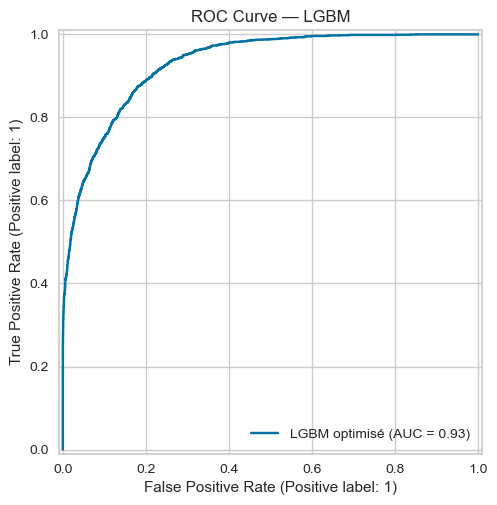

In [86]:
#  Courbe ROC 
RocCurveDisplay.from_predictions(y_test, y_proba_best_lgbm, name="LGBM optimisé")
plt.title("ROC Curve — LGBM")
plt.show()

>La courbe ROC montre que le modèle optimisé a une bonne capacité de discrimination, avec un taux de vrais positifs élevé même pour un faible taux de faux positifs. La courbe orange s’éloigne nettement de la diagonale (baseline), ce qui indique une performance bien supérieure au hasard.

c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.



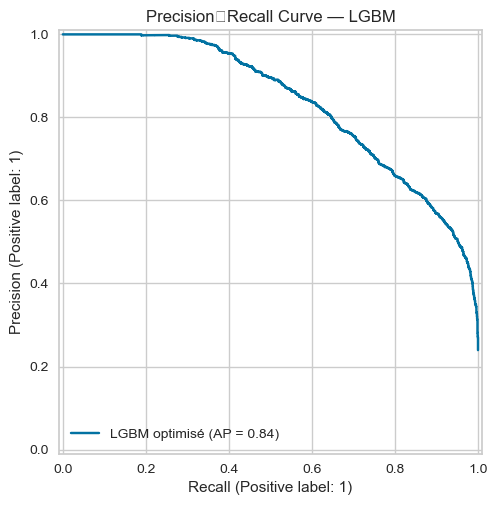

In [87]:
PrecisionRecallDisplay.from_predictions(y_test, y_proba_best_lgbm, name="LGBM optimisé")
plt.title("Precision‑Recall Curve — LGBM")
plt.show()

> Avec une moyenne de précision de 0.84, le modèle parvient globalement à bien identifier les cas positifs tout en limitant les faux positifs.

## Exportation du modéle

In [88]:
import dill
import os
os.makedirs("models", exist_ok=True)
with open("models/best_lgbm_model.dill", "wb") as f:
    dill.dump(best_lgbm_model, f)

## Étudier la feature importance global et local avec shap

Type des données transformées: <class 'numpy.ndarray'>
Shape: (9752, 47)
Nombre de caractéristiques: 47
Initialisation de TreeExplainer...
Calcul des valeurs SHAP...


c:\Users\HP\anaconda3\envs\env_ML2\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



Type de shap_values: <class 'numpy.ndarray'>
Shape de shap_values: (9752, 47)


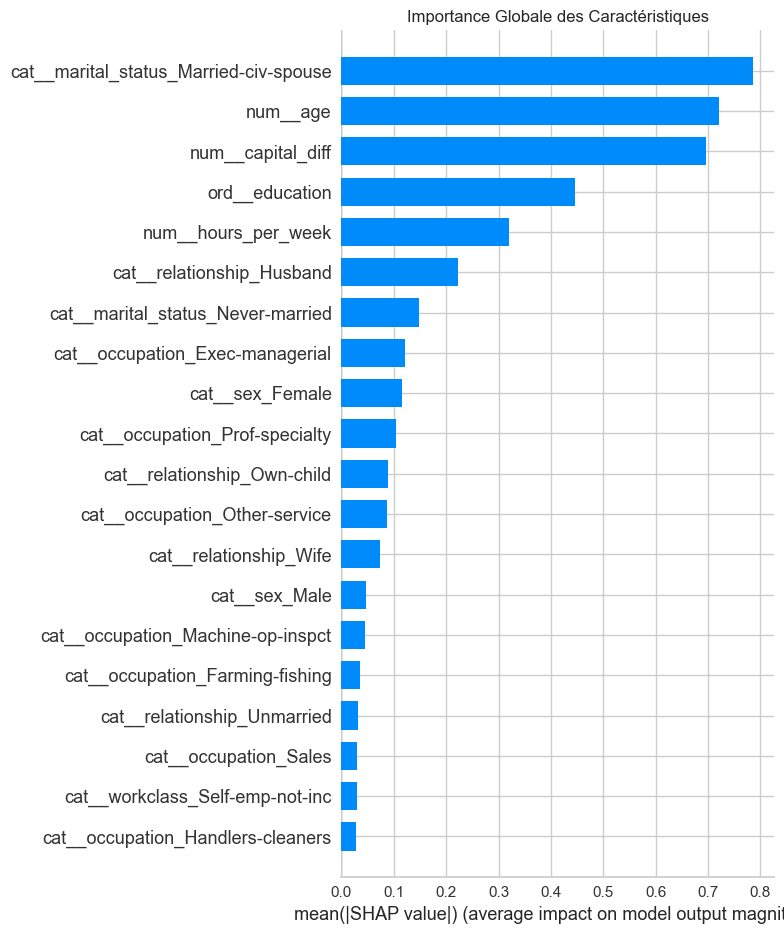

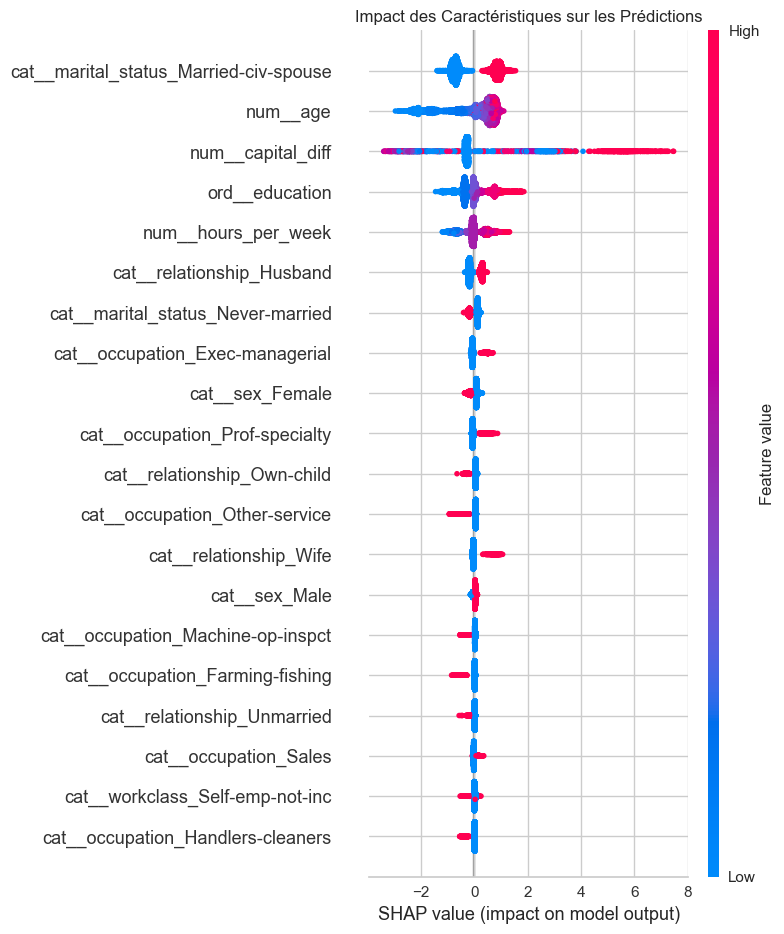


Exemple d'explication pour une observation:


In [ ]:
import shap

# 1. Extraire le meilleur modèle
best_estimator = rnd_search.best_estimator_  # Votre modèle après RandomizedSearchCV

# 2. Accéder au préprocesseur et au modèle LGBM dans le pipeline
preprocessor = best_estimator.named_steps['preprocessor']  # Adapter si le nom est différent
clf = best_estimator.named_steps['clf']  # LGBM Classifier

# 3. Transformer les données de test
X_test_transformed = preprocessor.transform(x_test)

# 4. Conversion en array numpy dense si nécessaire
if hasattr(X_test_transformed, 'toarray'):  # Pour les matrices sparse
    X_test_transformed = X_test_transformed.toarray()
X_test_transformed = np.ascontiguousarray(X_test_transformed, dtype=np.float32)

# 5. Obtenir les noms des caractéristiques
try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    try:
        feature_names = preprocessor.get_feature_names()
    except AttributeError:
        # Fallback avec des noms génériques si nécessaire
        feature_names = [f"feature_{i}" for i in range(X_test_transformed.shape[1])]

print(f"Type des données transformées: {type(X_test_transformed)}")
print(f"Shape: {X_test_transformed.shape}")
print(f"Nombre de caractéristiques: {len(feature_names)}")

# 6. Vérifier la correspondance entre le nombre de caractéristiques
if len(feature_names) != X_test_transformed.shape[1]:
    print(f"ATTENTION: Nombre de noms de caractéristiques ({len(feature_names)}) ne correspond pas aux données ({X_test_transformed.shape[1]})")
    # Adapter la liste des noms si nécessaire
    if len(feature_names) < X_test_transformed.shape[1]:
        # Ajouter des noms génériques pour les caractéristiques manquantes
        feature_names = list(feature_names) + [f"feature_{i}" for i in range(len(feature_names), X_test_transformed.shape[1])]
    else:
        # Tronquer la liste si trop longue
        feature_names = feature_names[:X_test_transformed.shape[1]]
    
    print(f"Liste de noms ajustée à la longueur {len(feature_names)}")

# 7. Appliquer SHAP - utiliser TreeExplainer pour LGBM
try:
    print("Initialisation de TreeExplainer...")
    explainer = shap.TreeExplainer(clf)
    
    # Calculer les valeurs SHAP
    print("Calcul des valeurs SHAP...")
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Afficher des informations sur les valeurs SHAP
    print(f"Type de shap_values: {type(shap_values)}")
    if isinstance(shap_values, list):
        print(f"Nombre de classes: {len(shap_values)}")
        for i, sv in enumerate(shap_values):
            print(f"Shape pour la classe {i}: {sv.shape}")
    else:
        print(f"Shape de shap_values: {shap_values.shape}")
    
    # Plot d'importance globale des caractéristiques
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list) and len(shap_values) > 1:
        # Pour classification binaire - prendre la classe positive (1)
        shap.summary_plot(
            shap_values[1],
            X_test_transformed,
            feature_names=feature_names,
            plot_type="bar",
            show=False
        )
        plt.title("Importance Globale des Caractéristiques (Classe >50k)")
    else:
        # Pour valeurs SHAP à une seule dimension
        shap.summary_plot(
            shap_values,
            X_test_transformed,
            feature_names=feature_names,
            plot_type="bar",
            show=False
        )
        plt.title("Importance Globale des Caractéristiques")
    
    plt.tight_layout()
    plt.show()
    
    # Plot de dépendance (beeswarm)
    plt.figure(figsize=(12, 8))
    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap.summary_plot(
            shap_values[1],
            X_test_transformed,
            feature_names=feature_names,
            show=False
        )
        plt.title("Impact des Caractéristiques sur les Prédictions (Classe >50k)")
    else:
        shap.summary_plot(
            shap_values,
            X_test_transformed,
            feature_names=feature_names,
            show=False
        )
        plt.title("Impact des Caractéristiques sur les Prédictions")
    
    plt.tight_layout()
    plt.show()
    
    # Explication locale pour une observation
    print("\nExemple d'explication pour une observation:")
    shap.initjs()
    
    # Pour classification binaire
    if isinstance(shap_values, list) and len(shap_values) > 1:
        display(shap.force_plot(
            explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
            shap_values[1][0,:],
            feature_names=feature_names
        ))
    else:
        display(shap.force_plot(
            explainer.expected_value if hasattr(explainer, 'expected_value') else 0,
            shap_values[0,:],
            feature_names=feature_names
        ))

except Exception as e:
    print(f"Erreur avec TreeExplainer: {str(e)}")
    print("Tentative avec KernelExplainer...")
    
    # Fallback à KernelExplainer (limité à 100 exemples pour performance)
    # Utiliser uniquement un sous-ensemble pour la démonstration car KernelExplainer est lent, trop lent 
    sample_size = min(100, X_test_transformed.shape[0])
    X_sample = X_test_transformed[:sample_size]
    
    # Définir un predict_proba qui fonctionne avec des données déjà transformées
    def model_predict(X):
        return clf.predict_proba(X)
    
    explainer = shap.KernelExplainer(model_predict, X_sample)
    sample_explain = min(10, sample_size)
    shap_values = explainer.shap_values(X_sample[:sample_explain])
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(
        shap_values[1] if isinstance(shap_values, list) else shap_values,
        X_sample[:sample_explain],
        feature_names=feature_names,
        plot_type="bar",
        show=False
    )
    plt.title("Importance Globale des Caractéristiques (KernelExplainer)")
    plt.tight_layout()
    plt.show()

1. Importance globale des caractéristiques (barplot)

> Le graphique en barres classe les variables selon leur contribution moyenne absolue à la sortie du modèle. On y voit clairement que le statut marital « Married-civ-spouse » arrive en tête, ce qui signifie qu’être marié·e civilement a, en moyenne, l’impact le plus fort sur la prédiction d’un revenu élevé. Viennent ensuite l’« âge » (num__age) et la différence de capital (num__capital_diff) : plus une personne est âgée et plus elle a de gains nets de capital, plus le modèle la considère comme susceptible de gagner plus de 50 000 $. L’éducation ordinale (ord__education) et le nombre d’heures travaillées par semaine (num__hours_per_week) occupent également des positions élevées, confirmant l’importance de la formation et de l’investissement horaire dans la prédiction du revenu.

2. Impact des caractéristiques sur les prédictions 
>Le nuage de points coloré montre pour chaque individu la répartition des valeurs SHAP selon la valeur de la caractéristique (de bleu pour les faibles à magenta pour les fortes).

- Statut marital « Married-civ-spouse » : les points magenta à droite indiquent que, lorsqu’une personne est mariée civilement, son SHAP est fortement positif, poussant la prédiction vers un revenu élevé.

- Âge (num__age) : les observations les plus âgées (couleur magenta) ont des SHAP positifs, tandis que les plus jeunes (bleu) ont tendance à réduire la probabilité de revenu > 50 000 $.

- Capital_diff : un gain net de capital important (points magenta très à droite) peut générer des effets SHAP allant jusqu’à +8, montrant un fort signal sur le revenu élevé ; les pertes de capital (points plus bleus) infléchissent au contraire la prédiction dans la direction inverse.
> L’éducation suit une tendance similaire : un niveau d’éducation élevé (magenta) augmente la SHAP, donc la probabilité de revenu élevé. Les heures travaillées (num__hours_per_week) jouent aussi positivement lorsqu’elles sont supérieures à la moyenne. À l’inverse, le statut « Never‑married » se positionne plutôt à gauche (SHAP négatifs) lorsque la personne n’a jamais été mariée, ce qui réduit la probabilité de revenu élevé. De même, le fait d’être femme (cat__sex_Female) tend globalement à faire chuter la prédiction par rapport aux hommes, même si l’effet est moins marqué que pour le statut marital ou le capital.

Quelques constats sur les catégories professionnelles et relations familiales:

>Parmi les occupations, les postes Exec-managerial et Prof-specialty donnent plutôt des SHAP positifs (points magenta légèrement à droite), indiquant qu’ils contribuent à des revenus élevés, alors que les métiers de Handlers-cleaners ou Other-service sont positionnés du côté négatif. Enfin, la variable relationship_Husband (être marié·e avec un·e conjoint·e reconnu·e comme « husband ») renforce encore la probabilité de revenu élevé, alors que « Own-child » ou « Unmarried » ont l’effet inverse


> Le graphique d’explication locale commence par une valeur de base d’environ –2,31 en log‑odds, qui représente la prédiction moyenne du modèle avant de considérer les caractéristiques spécifiques de l’individu. Cette valeur sert de point de départ neutre : tout ce qui suit vient s’y ajouter (ou s’y soustraire) pour aboutir à la prédiction finale.

>Ensuite, plusieurs caractéristiques contribuent positivement à la prédiction d’un revenu supérieur à 50 000 $. Parmi elles, le fait d’être travailleur indépendant et d’occuper un rôle d’“époux”  pousse déjà le score vers le haut. L’appartenance à la catégorie professionnelle  et un nombre d’heures de travail par semaine élevé renforcent ce signal. Les statuts “married‑civ‑spouse”, un âge plus avancé et un niveau d’éducation supérieur viennent ensuite consolider la probabilité d’un revenu élevé. Ensemble, ces facteurs ajoutent plus de +4 en log‑odds au score initial.

>En revanche, la seule caractéristique à effet négatif ici est la différence de capital  : une valeur relativement faible de ce net de capital retire environ –2,31 en log‑odds de la prédiction. Cet effet atténue partiellement l’influence des autres facteurs, mais reste insuffisant pour renverser la tendance globale.

>Au final, après avoir combiné tous ces apports (positifs et négatifs), on obtient un score *f(x)* d’environ +1,97 en log‑odds, nettement supérieur à zéro. Concrètement, ce profil est considéré par le modèle comme très susceptible de percevoir un revenu annuel supérieur à 50 000 $


# FIN